# Старт

In [34]:
# Техно-библиотеки без которых никуда
import os
import xml.etree.ElementTree as pars
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
import numpy as np
from PIL import Image
import random

# Компьютерное зрение и визуализация
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import albumentations as A

# Нейросетки
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torch import nn
from torch import optim

# Диск
from google.colab import drive
drive.mount('/content/drive')

# Сажаем на свой диск
DRIVE_PATH = '/content/drive/MyDrive/DataScience[Практика]/Цифровой прорыв/'
%cd '/content/drive/MyDrive/DataScience[Практика]/Цифровой прорыв/'

# Только первый раз
# !rm -r reformatted_data
# !unzip -q 'reformatted_data.zip' -d 'stupido'

DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DataScience[Практика]/Цифровой прорыв


In [35]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
 
    def __setattr__(self, key, value):
        self.__setitem__(key, value)

        
config = DotDict()
# config.size = (460, 307)
config.epochs = 30
config.lr = 1e-4
config.batch_size = 32
config.val_size = 0.2 # Размер валидационной выборки относительно всех данных
config.increase_data_num = 1 # Во сколько раз раскопировать выборку
config.data_folder = 'reformatted_data'
config.make_transform = True
config.step_size = 30
config.gamma = 0.9
config.bear_value = 0.5

transforms1 = [#A.RandomCrop(224, 224, always_apply=True),               
               #A.RandomRotate90(p=0.7),
               #A.Flip(p=0.5),
              A.RandomBrightness(limit=0.3, always_apply=True),
              A.RandomGamma(always_apply=True),
              A.RandomContrast(limit=0.3, always_apply=True)]

normalize = A.Compose([A.RandomCrop(224, 224), 
                       A.Normalize()], bbox_params={'format':'pascal_voc'})
transform = A.Compose(transforms1, bbox_params={'format':'pascal_voc'})

# Загрузка данных

In [109]:
def to_torch_image(image):
    image = np.moveaxis(image, -1, 0)
    return torch.from_numpy(image)

def to_numpy_image(image):
    image = np.array(image)
    image = np.moveaxis(image, 0, -1)
    return image

def crop_by_bb(image, bboxes, size=200):
    if len(bboxes) > 0 and random.random() > 0.5:
        bbox = bboxes[0]
        xmin, ymin, xmax, ymax, name = bbox
        x = xmin + xmax
        x //= 2
        y = ymin + ymax
        y //= 2 
        crop_img = image[y - size:y + size, x - size:x + size]
        bbox = [[xmin - (x - size), ymin - (y - size), xmax - (x - size), ymax - (y - size), 'bear']]
        return crop_img, bbox
    else:
        w, h, c = image.shape
        t = A.RandomCrop(2 * size, 2 * size)
        transform = A.Compose([t], bbox_params={'format':'pascal_voc'})
        transformed = transform(image=image, bboxes=bboxes)
        image = transformed['image']
        bboxes = transformed['bboxes']
    return image, bboxes


class BearsDataset(Dataset):
    def __init__(self, 
                root_folder,
                transform=None,
                increase_data_size_num=5):
        super().__init__()
        self.transform = transform
        self.folder = root_folder

        self.names = []
        for _ in range(increase_data_size_num):
            self.names.extend(self.load_names())
        

    def load_names(self):
        names_list = []
        for filename in os.listdir(self.folder + "/images/"):
            part_name = filename.split('.')[0]
            names_list.append(part_name)
        return names_list

    def load_image(self, name):
        img = cv2.imread(os.path.join(self.folder, 'images', name + '.JPG'))
        return img

    def load_bboxes(self, name):
        bboxes = []
        annot_path = os.path.join(self.folder, 'annotations', name + '.xml')
        if os.path.exists(annot_path):
            e = pars.parse(annot_path)
            root = e.getroot()
            for obj in root.findall('object'):
                name = obj.find('name').text
                for box in obj.findall('bndbox'):
                    points = [int(box.find('xmin').text),
                              int(box.find('ymin').text),
                              int(box.find('xmax').text),
                              int(box.find('ymax').text),
                              'bear']
                    if points[1] != points[3] and points[0] != points[2]:
                        bboxes.append(points)
        return bboxes

    def __len__(self):
        return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        image = self.load_image(name)
        bboxes = self.load_bboxes(name)
        if not ('reformatted_data' in config.data_folder):
            image, bboxes = crop_by_bb(image, bboxes)
            if self.transform:
                transformed = self.transform(image=image, bboxes=bboxes)
                image = transformed['image']
                bboxes = transformed['bboxes']
        image = to_torch_image(image)
        return image, bboxes


class PostTrainBearsDataset(Dataset):
    def __init__(self, 
                root_folder,
                transform=normalize):
        super().__init__()
        self.transform = transform
        self.folder = root_folder

        self.names = []
        self.names = self.load_names()
        

    def load_names(self):
        names_list = []
        for filename in os.listdir(self.folder + "/0/"):
            part_name = '0/' + filename.split('.')[0]
            names_list.append(part_name)
        for filename in os.listdir(self.folder + "/1/"):
            part_name = '1/' + filename.split('.')[0]
            names_list.append(part_name)
        return names_list

    def load_image(self, name):
        img = cv2.imread(os.path.join(self.folder, name + '.JPG'))
        return img

    def load_mark(self, name):
        return int(name[0])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        image = self.load_image(name)
        mark = self.load_mark(name)
    
        if self.transform:
            transformed = self.transform(image=image, bboxes=[])
            image = transformed['image']

        image = to_torch_image(image)
        return image, mark

In [110]:
t = None
if config.make_transform:
    t = transform
    
ds = BearsDataset(config.data_folder, transform=t, increase_data_size_num=config.increase_data_num)
val_size = config.val_size
train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])
print(len(train_ds), len(val_ds))

1056 264


In [132]:
ds = PostTrainBearsDataset('to_retrain')
val_size = config.val_size
train_ds_p, val_ds_p = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])
print(len(train_ds_p), len(val_ds_p))

65 16


In [112]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=config.batch_size, collate_fn=collate_fn)
if len(val_ds):
    val_dl = DataLoader(val_ds, shuffle=True, drop_last=True, batch_size=config.batch_size, collate_fn=collate_fn)

In [133]:
train_dl_p = DataLoader(train_ds_p, shuffle=True, drop_last=True, batch_size=2, collate_fn=collate_fn)
if len(val_ds):
    val_dl_p = DataLoader(val_ds_p, shuffle=True, drop_last=True, batch_size=2, collate_fn=collate_fn)

# Для предсказаний


In [114]:
def area_of_intersection(coords1, coords2):
    """ Посчитаем площадь пересечения """
    x1, y1, x2, y2 = coords1
    x3, y3, x4, y4 = coords2

    # границы области пересечения
    left = max(x1, x3)  # левая
    bottom = max(y1, y3)  # нижняя
    right = min(x2, x4)  # правая
    top = min(y2, y4)  # верхняя

    width = right - left
    height = top - bottom

    if width <= 0 or height <= 0:
        area = 0
    else:
        area = width * height
    return area


def area(coords):
    """ Посчитаем площадь """
    x1, y1, x2, y2 = coords
    return (x2 - x1) * (y2 - y1)

In [115]:
def iou(points, predicted_points):
    """
    IoU = Area of Intersection / Area of Union
    """
    xA = max(points[0], predicted_points[0])
    yA = max(points[1], predicted_points[1])
    xB = min(points[2], predicted_points[2])
    yB = min(points[3], predicted_points[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (points[2] - points[0] + 1) * (points[3] - points[1] + 1)
    boxBArea = (predicted_points[2] - predicted_points[0] + 1) * (predicted_points[3] - predicted_points[1] + 1)

    iou = intersection_area / float(boxAArea + boxBArea - intersection_area)

    return iou

# Визуализация

In [116]:
def show_img(image, bboxes=[], show_grid=False, figsize=(8, 8), size=None):
    """ 
    image: каринтка
    bboxes: координаты медведей
    show_grid: показывать ли сетку
    figsize: размер для отображения
    size: фактический размер изображения
    """

    plt.subplots(figsize=figsize)
    if isinstance(image, torch.Tensor):
        image = to_numpy_image(image)
    image = image.copy()
    for bear in bboxes:
        x1, y1, x2, y2 = bear
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), int(1 * image.shape[0] / 448))
    if size:
        cv2.resize(image, size)
    # image = np.array(image, dtype=np.uint8)
    plt.title(f'Bears: {len(bboxes)}')
    img = image.copy()
    for bear in bboxes:
        x1, y1, x2, y2 = bear
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), int(1 * image.shape[0] / 224))
    plt.imshow(img)
    if not show_grid:
        plt.axis('off')
    plt.show()
    return image

In [117]:
# for X, y in train_ds:
#     plt.imshow(to_numpy_image(X))
#     plt.show()

# Классификатор

In [168]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        model = models.resnet101(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

        self.model = model
        self.end_layer = nn.Sequential(
            nn.Linear(1000, 128),
            nn.Linear(128, 1)
        )

    def forward(self, X):
        return self.end_layer(self.model(X))
    
    def __call__(self, X):
        return self.forward(X)

In [139]:
model = ResNet().to(device)
model.load_state_dict(torch.load('checkpoints/ResNet101-best.pth'))
optimizer = optim.Adam(model.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)

## Тренировка

In [140]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve

def accuracy(y_batch, pred_batch):
    acc = 0
    for pred, y in zip(pred_batch, y_batch):
        pred = int(pred > config.bear_value)
        acc += int(pred == y)
    acc /= len(pred_batch)
    return acc


class Statistic:
    def __init__(self):
        self.data = {'accuracy-train':[],
                            'recall-train':[],
                            'precision-train':[],
                            'roc_curve-train':[],
                            'accuracy-val':[],
                            'recall-val':[],
                            'precision-val':[],
                            'roc_curve-val':[]}
        
        self.funcs = {'accuracy':accuracy,
                      'recall':recall_score,
                      'precision':precision_score,
                      'roc_curve':roc_curve}
    
    def add_preds(self, y_true, y_pred, val=True):
        if val:
            mode = '-val'
        else:
            mode = '-train'
        for key in self.funcs.keys():
            self.data[key + mode].append(np.mean(
                self.funcs[key](y_true.detach().cpu(), y_pred.detach().cpu())))
    
    def print_last(self):
        for key in list(self.data.keys())[:4]:
            print(f'{key:15}: {self.data[key][-1]:.5f}')
        print()
        for key in list(self.data.keys())[4:]:
            print(f'{key:15}: {self.data[key][-1]:.5f}')
            

def from_detection_pred_to_classifier_pred_batch(y_batch):
    new_batch = []
    for y in y_batch:
        new_batch.append(torch.Tensor([int(len(y) > 0)]))
    return torch.Tensor(new_batch)

def train_classifier(model, optimizer, sched, epochs, data_tr, data_val, metric, crit=nn.MSELoss(), post_train=False):
    best_w = model.state_dict()
    last_loss = 999
    stats = Statistic()

    losses_train = []
    losses_val = []

    for i in trange(epochs):
        model.train()
        loss_train = []
        for X, y in tqdm(data_tr):
            X = torch.stack(X)
            X = X.to(device)
            
            if not post_train:
                y = from_detection_pred_to_classifier_pred_batch(y)
            y = torch.Tensor(y).to(device)
            y = y.squeeze()
            
            optimizer.zero_grad()
            pred = torch.sigmoid(model(X))
            pred = pred.squeeze(1)

            loss = crit(pred, y)
            loss_train.append(loss.detach().cpu())
            loss.backward()
            optimizer.step()
            sched.step()

            pred = torch.tensor(pred > 0.5, dtype=torch.float)
            stats.add_preds(y, pred, val=False)
        loss_train = np.mean(np.array(loss_train))
        losses_train.append(loss_train)

        model.eval()
        loss_val = []
        for X, y in data_val:
            X = torch.stack(X)
            X = X.to(device)
            
            if not post_train:
                y = from_detection_pred_to_classifier_pred_batch(y)
            y = torch.Tensor(y).to(device)
            y = y.squeeze()

            with torch.no_grad():
                pred = model(X)
                pred = torch.sigmoid(model(X))
                pred = pred.squeeze(1)

                loss_val.append(crit(pred, y).item())

                pred = torch.tensor(pred > config.bear_value, dtype=torch.float)
                stats.add_preds(y, pred, val=True)
                print(pred)
                print(y)

        loss_val = np.mean(loss_val)
        losses_val.append(loss_val)

        if loss_val < last_loss:
            last_loss = loss_val
            best_w = model.state_dict()
        print(f'----------|Epoch: {i:2}|----------')
        print(f'loss-train: {loss_train}')
        print(f'  loss-val: {loss_val}')
        print()
        stats.print_last()
        
    model.load_state_dict(best_w)
    return model, stats, losses_train, losses_val

In [141]:
# model, statistics, losses_train, losses_val = train_classifier(model, optimizer, scheduler, config.epochs, 
#                                      train_dl, val_dl, accuracy,
#                                      crit=nn.MSELoss())

In [142]:
model, statistics, losses_train, losses_val = train_classifier(model, optimizer, scheduler, 6, 
                                     train_dl_p, val_dl_p, accuracy,
                                     crit=nn.MSELoss(), post_train=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)



tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
----------|Epoch:  0|----------
loss-train: 0.2857069969177246
  loss-val: 0.21754037227511525

accuracy-train : 1.00000
recall-train   : 1.00000
precision-train: 1.00000
roc_curve-train: 0.66667

accuracy-val   : 1.00000
recall-val     : 1.00000
precision-val  : 1.00000
roc_curve-val  : nan



tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
----------|Epoch:  1|----------
loss-train: 0.3613341152667999
  loss-val: 0.1504109975002681

accuracy-train : 0.50000
recall-train   : 0.00000
precision-train: 0.00000
roc_curve-train: nan

accuracy-val   : 1.00000
recall-val     : 1.00000
precision-val  : 1.00000
roc_curve-val  : 0.66667



tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
----------|Epoch:  2|----------
loss-train: 0.2721582353115082
  loss-val: 0.11704846637307309

accuracy-train : 1.00000
recall-train   : 1.00000
precision-train: 1.00000
roc_curve-train: 0.66667

accuracy-val   : 1.00000
recall-val     : 1.00000
precision-val  : 1.00000
roc_curve-val  : 0.66667



tensor([1., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
----------|Epoch:  3|----------
loss-train: 0.3051794171333313
  loss-val: 0.21185223694582778

accuracy-train : 0.50000
recall-train   : 0.00000
precision-train: 0.00000
roc_curve-train: nan

accuracy-val   : 0.50000
recall-val     : 0.00000
precision-val  : 0.00000
roc_curve-val  : nan



tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
----------|Epoch:  4|----------
loss-train: 0.2903197407722473
  loss-val: 0.06771331029712258

accuracy-train : 1.00000
recall-train   : 1.00000
precision-train: 1.00000
roc_curve-train: 0.66667

accuracy-val   : 1.00000
recall-val     : 0.00000
precision-val  : 0.00000
roc_curve-val  : nan



tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
tensor([1., 1.], device='cuda:0')
tensor([1., 0.], device='cuda:0')
----------|Epoch:  5|----------
loss-train: 0.27227044105529785
  loss-val: 0.16754549944408126

accuracy-train : 1.00000
recall-train   : 1.00000
precision-train: 1.00000
roc_curve-train: 0.66667

accuracy-val   : 0.50000
recall-val     : 1.00000
precision-val  : 0.50000
roc_curve-val  : 0.83333



In [144]:
torch.save(model.state_dict(), 'checkpoints/ResNet-post.pth')

# Детектор

In [26]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
clear_output()
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.WEIGHTS = 'checkpoints/bear_detect_model.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
detector = DefaultPredictor(cfg)

# Всякие классы

In [175]:
class Data:
    def __init__(self, data):
        self.data = data
        self.length = len(data)

    def __getitem__(self, i):
        if isinstance(self.data, str): # Путь до картнки
            image = cv2.imread(self.data[i])
        elif isinstance(self.data, torch.Tensor):
            if len(self.data.shape) == 3: # Картинка
                image = to_numpy_image(self.data[i])
            elif len(self.data.shape) == 4: # Батч картинок
                image = to_numpy_image(self.data[i])
        elif isinstance(self.data, list):
            if isinstance(self.data[i], str):
                image = cv2.imread(self.data[i]) # Если путь
            else:
                image = self.data[i]
        else:
            image = self.data[i]
        return image
    
    def __len__(self):
        return self.length
    
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        x = self.__getitem__(self.n)
        self.n += 1
        if self.n < self.length:
            return x
        raise StopIteration


class Cutter:
    def __init__(self, data, size=224, step_size=200):
        self.size = size
        self.step_size = step_size
        self.data = data
        self.length = len(self.data)
    
    def __getitem__(self, i):
        image = self.data[i]
        images = []
        for r in range(0, image.shape[0], self.step_size):
            for c in range(0, image.shape[1], self.step_size):
                new_image = image[r:r + self.size, c:c + self.size, :]
                if new_image.shape == (self.size, self.size, 3):
                    images.append([new_image, [c, r, c, r]])
        return images
    
    def __len__(self):
        return self.length

    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        x = self.__getitem__(self.n)
        self.n += 1
        if self.n < self.length:
            return x
        raise StopIteration

class Predictor:
    def __init__(self, model, raw_data, show_img=False):
        data = Data(raw_data)
        self.model = model
        self.cutter = Cutter(data)
        self.length = len(self.cutter)
        self.show_img = show_img

    def __getitem__(self, i):
        self.model.eval()
        images =  self.cutter[i]
        for cutted_image in tqdm(images):
            image, coords = cutted_image
            preds = self.model(image)
            if not isinstance(preds, list):
                output = preds["instances"][preds['instances'].get_fields()['scores'] > 0.92]
                preds = list(list(output.get_fields()['pred_boxes']))
                preds = [list(map(lambda x: x.item(), list(preds[i]))) for i in range(len(preds))]
                coords = np.array(coords)
                coords = np.array([int(coords[1]), int(coords[0]),
                                int(coords[1]), int(coords[0])])
                preds = np.array(preds, dtype=np.int)
                if self.show_img:
                    show_img(image, preds, figsize=(5, 5))

            if len(preds) > 0:
                preds = preds + coords
    
    def __len__(self):
        return self.length
    
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        x = self.__getitem__(self.n)
        self.n += 1
        if self.n < self.length:
            return x
        raise StopIteration

# BearCatcher

In [176]:
!rm -r to_retrain
!mkdir to_retrain
!mkdir to_retrain/1
!mkdir to_retrain/0

class BearCatcher(nn.Module):
    def __init__(self, classifier, detector):
        super().__init__()
        self.classifier = classifier
        self.detector = detector
        self.x = 0
    
    def forward(self, X):
        self.x += 1
        detection = []
        normed = normalize(image=X, bboxes=[])['image']
        z = to_torch_image(normed)
        z = z.unsqueeze(0).to(device)
        z = self.classifier(z)
        z = torch.sigmoid(z)
        if z <= 0.955:
            return detection
        # show_img(X, [], figsize=(3, 3))
        # print(z)
        # correct = int(input('Correct res:')) 
        # cv2.imwrite(f'to_retrain/{correct}/{self.x}.JPG', X)
        X = np.array(X, dtype=np.uint8)
        detection = self.detector(X)
        return detection


    def __call__(self, X):
        return self.forward(X)

In [177]:
classifier = ResNet().to(device)
classifier.load_state_dict(torch.load('checkpoints/ResNet101-best.pth'))

<All keys matched successfully>

In [178]:
# detector = 
# detector.load_state_dict(torch.load('checkpoints/bear_detect_model.pth'))

In [179]:
model = BearCatcher(classifier, detector).to(device)
clear_output()

In [180]:
path = 'data/images'
names = os.listdir(path)
paths = [os.path.join(path, name) for name in names]
predictor = Predictor(model, paths, True)

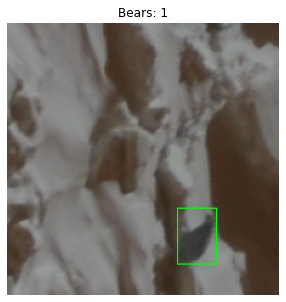

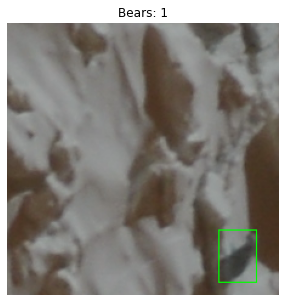

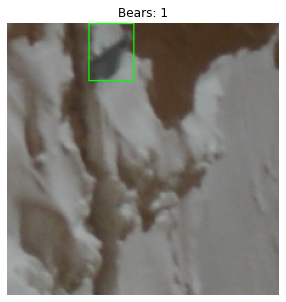

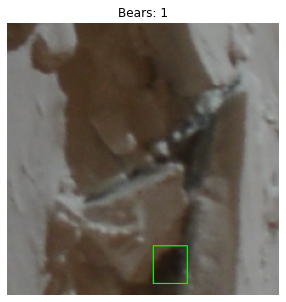

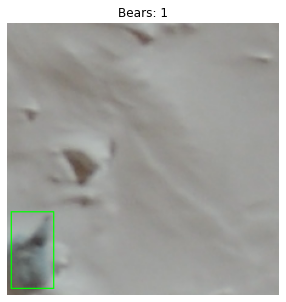

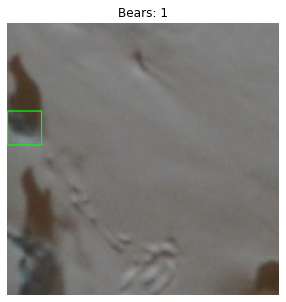

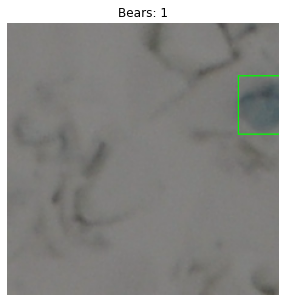

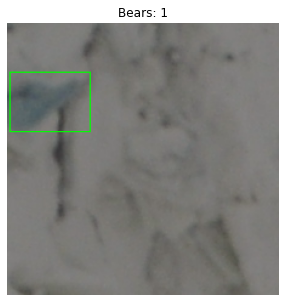

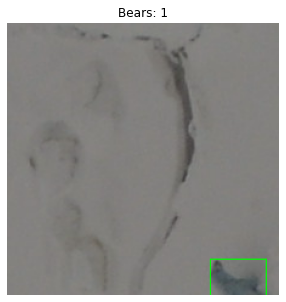

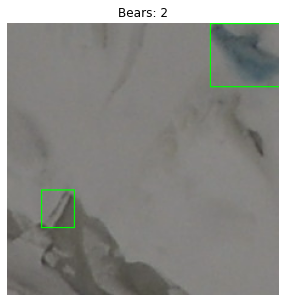

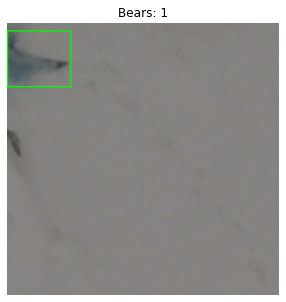

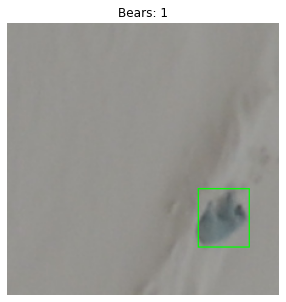

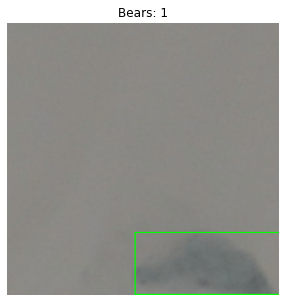

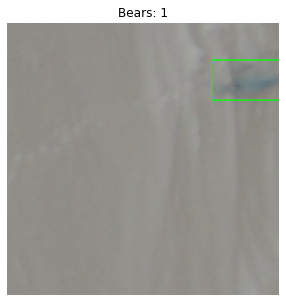

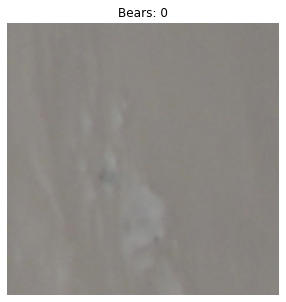

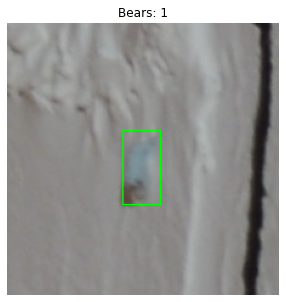

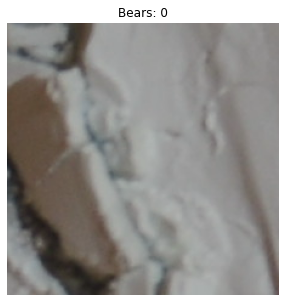

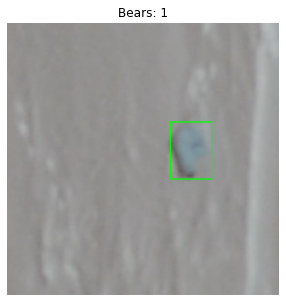

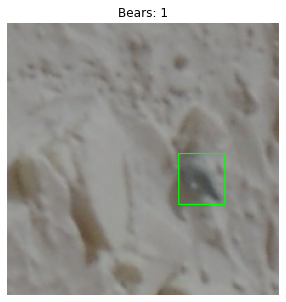

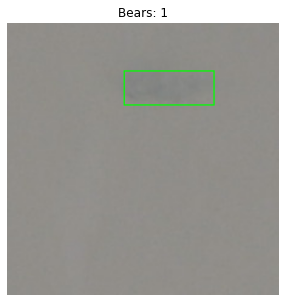

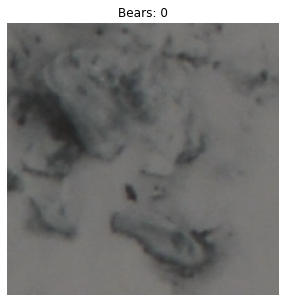

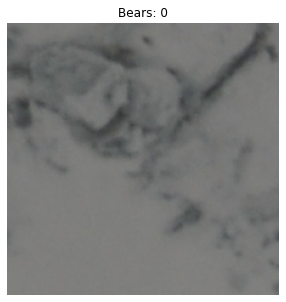

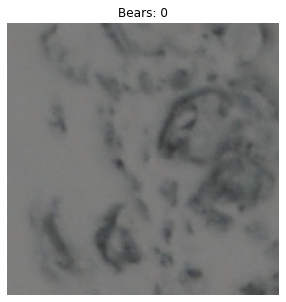

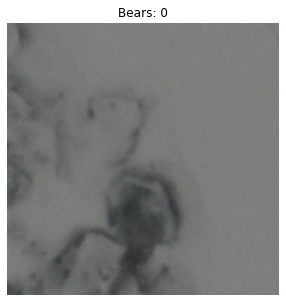

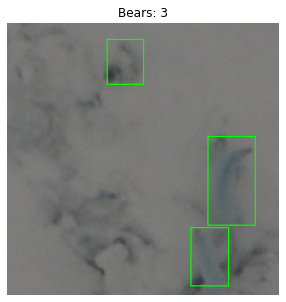

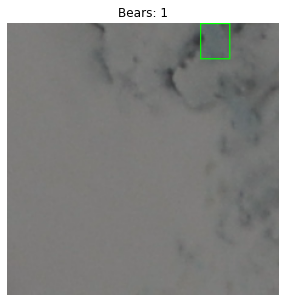

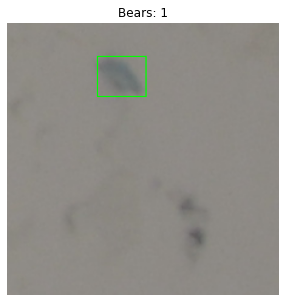

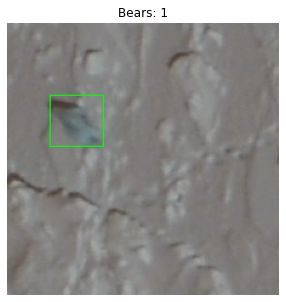

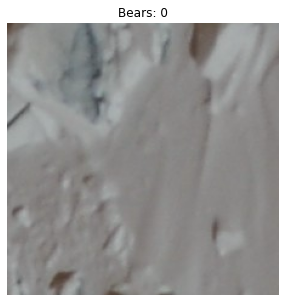

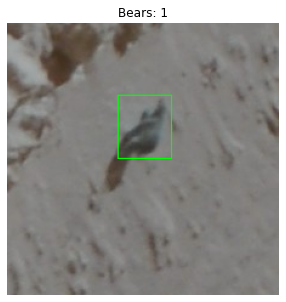

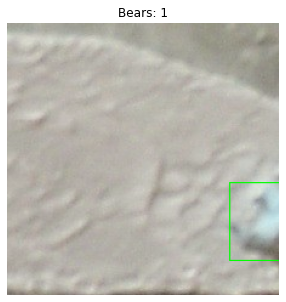

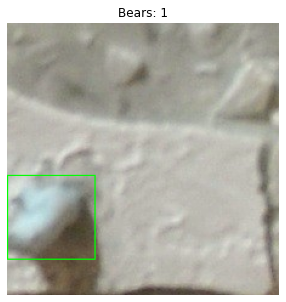

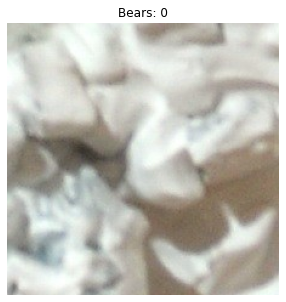

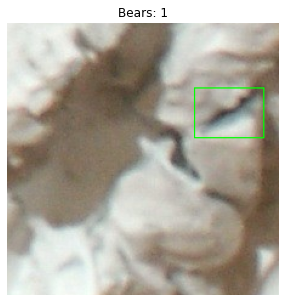

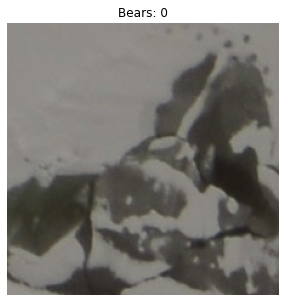

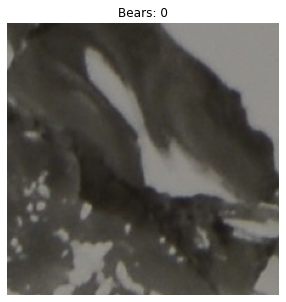

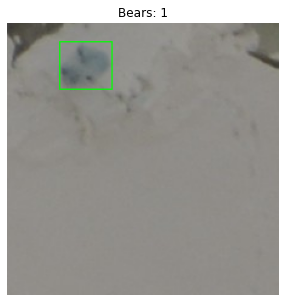

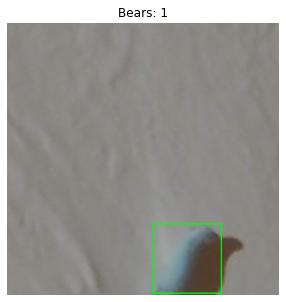

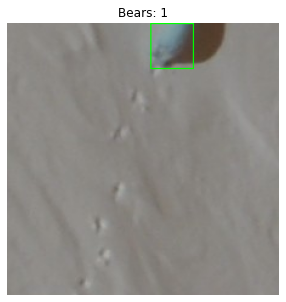

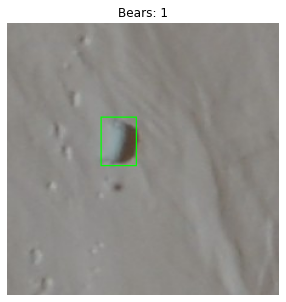

In [181]:
for img in predictor:
    pass

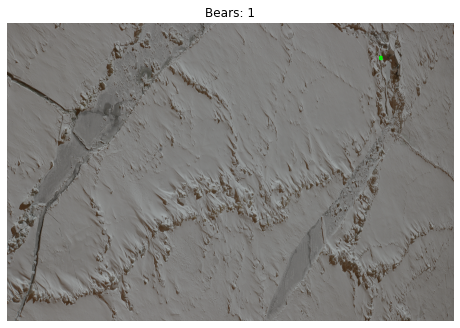

[array([6140,  552, 6172,  598])]


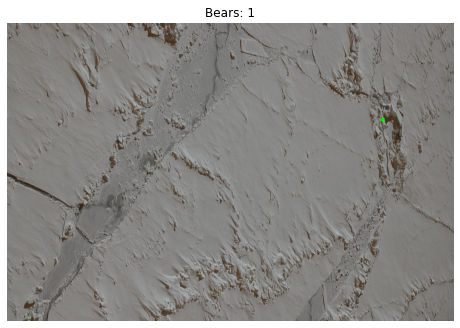

[array([6174, 1570, 6205, 1613])]


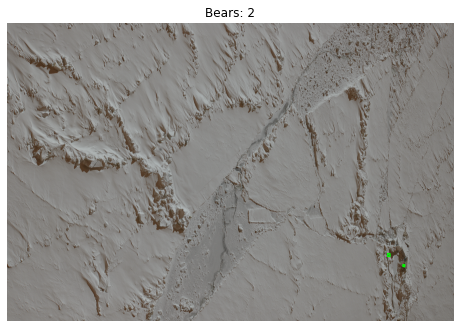

[array([6267, 3800, 6304, 3847]), array([6520, 3983, 6548, 4014])]


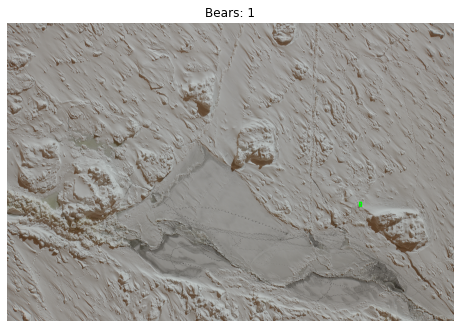

[array([5803, 2955, 5838, 3018])]


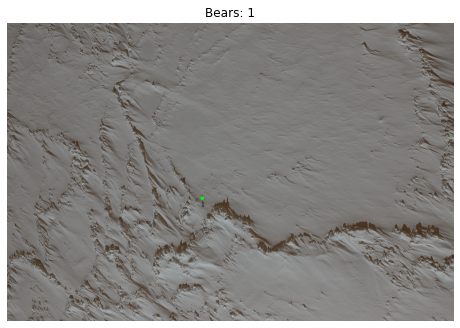

[array([3200, 2872, 3228, 2900])]


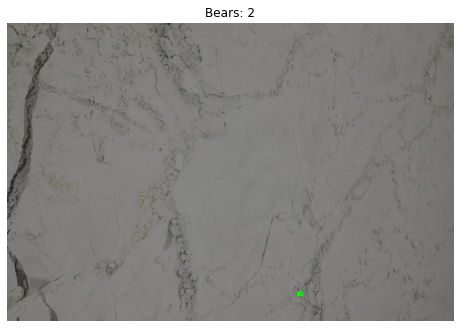

[array([4790, 4443, 4824, 4491]), array([4802, 4440, 4868, 4489])]


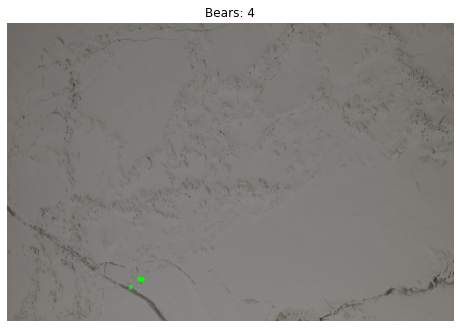

[array([2167, 4194, 2213, 4224]), array([2167, 4200, 2224, 4252]), array([2028, 4337, 2055, 4368]), array([2200, 4206, 2252, 4252])]


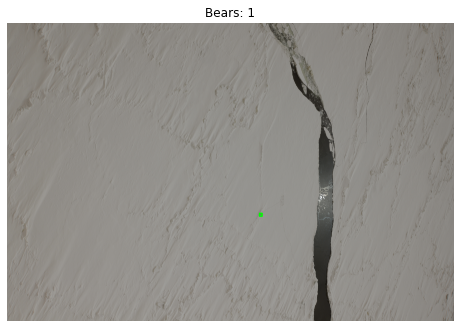

[array([4157, 3136, 4199, 3184])]


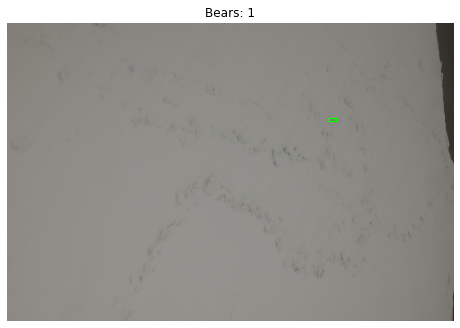

[array([5305, 1572, 5424, 1623])]


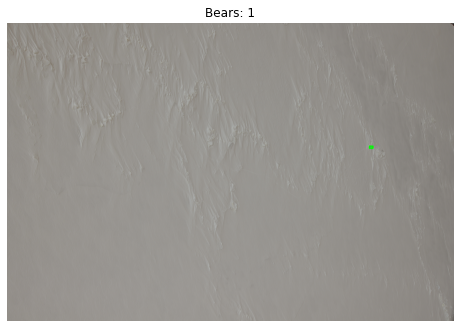

[array([5968, 2030, 6024, 2063])]


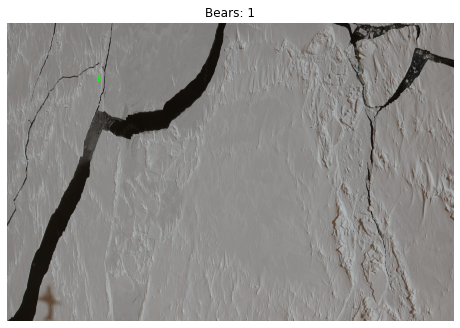

[array([1495,  888, 1526,  949])]


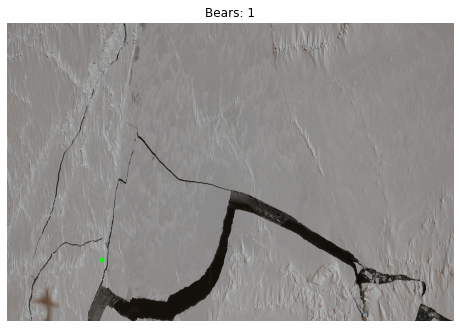

[array([1534, 3881, 1568, 3928])]


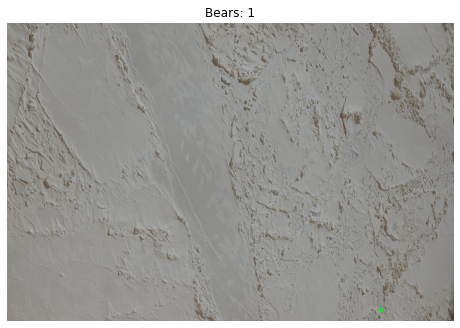

[array([6141, 4707, 6179, 4749])]


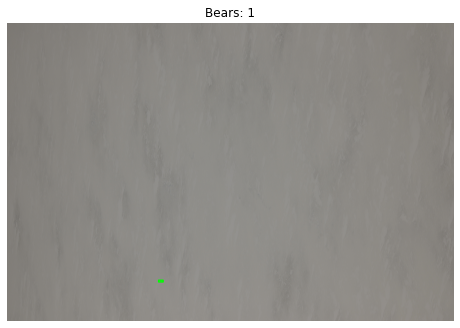

[array([2496, 4239, 2570, 4267])]


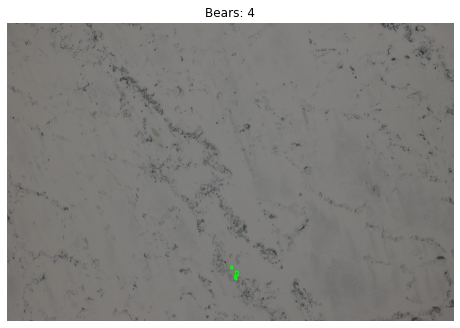

[array([3751, 4168, 3782, 4216]), array([3682, 4013, 3712, 4050]), array([3765, 4093, 3804, 4166]), array([3759, 4200, 3783, 4229])]


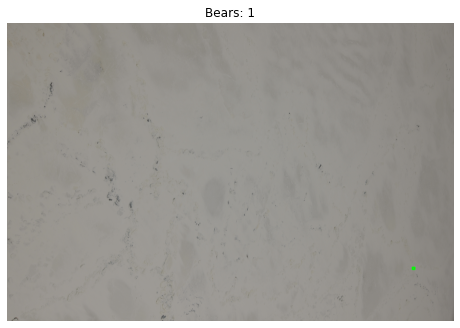

[array([6674, 4027, 6714, 4060])]


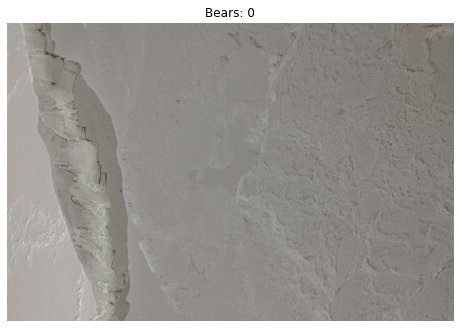

[]


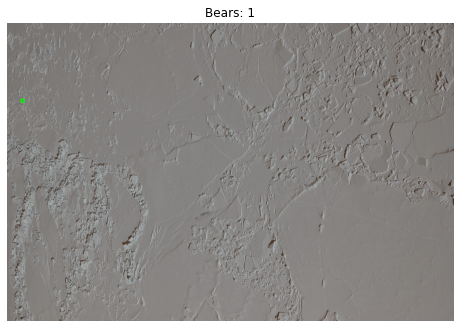

[array([ 235, 1259,  279, 1301])]


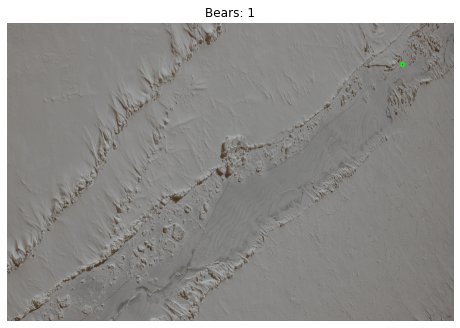

[array([6491,  659, 6535,  711])]


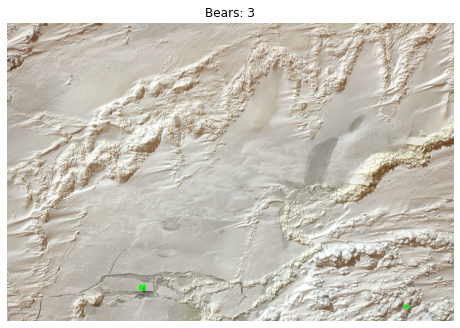

[array([2183, 4331, 2224, 4395]), array([2200, 4325, 2272, 4394]), array([6554, 4653, 6611, 4694])]


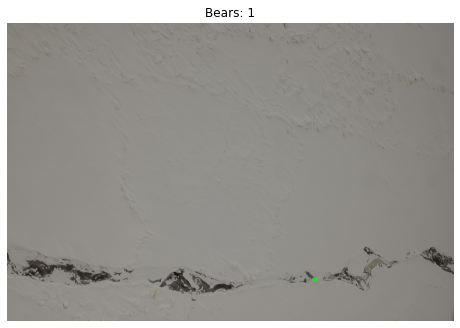

[array([5043, 4215, 5086, 4254])]


In [ ]:
!rm -r 'preds'
!mkdir 'preds'
for i, (image, bboxes) in enumerate(zip(data, absolute_bboxes)):
    img = show_img(image, bboxes)
    print(bboxes)
    cv2.imwrite(f'preds/{i}.JPG', img)

# Сохранение аугментированных данных

In [ ]:
from lxml import etree
# !rm -r reformatted_data
# !mkdir reformatted_data
# !mkdir reformatted_data/images
# !mkdir reformatted_data/annotations

path_im = os.path.join('for_a_sec_2', 'images')
path_annot = os.path.join('for_a_sec_2', 'annotations')
length = len(train_ds)
bears = 0
for i, (X, y_all) in enumerate(train_ds):
    X = to_numpy_image(X)
    cv2.imwrite(os.path.join(path_im, str(i) + '.JPG'), X)
    
    if len(y_all) > 0:
        bears += 1
    
    root = etree.Element('annotation')
    for y in y_all:
        obj = etree.Element('object')
        bbox = etree.Element('bndbox')
        xmin = etree.Element('xmin')
        xmin.text = str(int(y[0]))
        ymin = etree.Element('ymin')
        ymin.text = str(int(y[1]))
        xmax = etree.Element('xmax')
        xmax.text = str(int(y[2]))
        ymax = etree.Element('ymax')
        ymax.text = str(int(y[3]))
        bbox.append(xmin)
        bbox.append(ymin)
        bbox.append(xmax)
        bbox.append(ymax)
        name = etree.Element('name')
        name.text = "bear"
        obj.append(name)
        obj.append(bbox)
        root.append(obj)
    
    et = etree.ElementTree(root)
    et.write(os.path.join(path_annot, str(i) + '.xml'), pretty_print=True)

    print(f'{i:3} / {length} | {bears / (i + 1):.4f}')

  0 / 30 | 0.0000
  1 / 30 | 0.5000
  2 / 30 | 0.6667
  3 / 30 | 0.7500
  4 / 30 | 0.6000
  5 / 30 | 0.5000
  6 / 30 | 0.4286
  7 / 30 | 0.3750
  8 / 30 | 0.4444
  9 / 30 | 0.4000
 10 / 30 | 0.4545
 11 / 30 | 0.4167
 12 / 30 | 0.3846
 13 / 30 | 0.4286
 14 / 30 | 0.4000
 15 / 30 | 0.4375
 16 / 30 | 0.4118
 17 / 30 | 0.4444
 18 / 30 | 0.4737
 19 / 30 | 0.4500
 20 / 30 | 0.4286
 21 / 30 | 0.4545
 22 / 30 | 0.4783
 23 / 30 | 0.5000
 24 / 30 | 0.5200
 25 / 30 | 0.5385
 26 / 30 | 0.5185
 27 / 30 | 0.5357
 28 / 30 | 0.5517
 29 / 30 | 0.5667


# Playground


In [ ]:
# new_image = image[r:r + size, c:c + size, :]
                    # print(new_image.shape)
                    # row_pad = size - new_image.shape[0]
                    # col_pad = size - new_image.shape[1]
                    # if row_pad % 2:
                    #     new_image = np.pad(new_image, ((row_pad // 2, row_pad // 2 + 1), (0, 0)), 'constant', constant_values=self.fill_color)
                    # if col_pad % 2:
                    #     new_image = np.pad(new_image, ((0, 0), (col_pad // 2, col_pad // 2 + 1)), 'constant', constant_values=self.fill_color)
                    # row_pad //= 2
                    # col_pad //= 2
                    # new_image = np.pad(new_image, ((row_pad, row_pad), (col_pad, col_pad), 'constan', constan_values=self.fill_color))
                    # print(new_image.shape)
                    # print('-' * 10)
                    # images.append(new_image)

# cut_transforms = A.Compose([A.Crop()], bbox_params={'format':'pascal_voc'})
                    # transformed = self.transform(image=image, bboxes=[])
                    # image = transformed['image']

In [ ]:
model.eval()
loss_val = []
for X, y in data_val:
    X = torch.stack(X)
    X = X.to(device)
    
    y = from_detection_pred_to_classifier_pred_batch(y)
    y = y.to(device)
    y = y.squeeze()

    with torch.no_grad():
        pred = model(X)
        pred = torch.sigmoid(model(X))
        pred = pred.squeeze(1)

        loss_val.append(crit(pred, y).item())

        pred = torch.tensor(pred > config.bear_value, dtype=torch.float)
        print(pred, y)